In [1]:
! pip install split-folders

In [2]:
!wget -O dataset.zip https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded
!unzip -qq dataset.zip -d dataset

--2022-12-05 13:19:14--  https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd [following]
--2022-12-05 13:19:16--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.218.46.106, 52.218.109.32, 3.5.64.174, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|52.218.46.106|:44

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img , img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPool2D, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3, ResNet50
from keras import Model
from keras.metrics import Precision, Recall

import numpy as np
from skimage import transform
import splitfolders
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

In [4]:
splitfolders.ratio(
  "/kaggle/working/dataset/Plant_leave_diseases_dataset_with_augmentation", 
  output="/kaggle/working/Final_Dataset",
  seed=7,
  ratio=(0.90, 0.050, 0.050)
)

Copying files: 61486 files [00:09, 6640.60 files/s]


In [5]:
    '''
    rotation_range=355,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    width_shift_range=0.1
    '''

'\nrotation_range=355,\nzoom_range=0.2,\nhorizontal_flip=True,\nvertical_flip=False,\nwidth_shift_range=0.1\n'

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1/255,

)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_dataset = train_datagen.flow_from_directory(
  '/kaggle/working/Final_Dataset/train',
  target_size=(200, 200),
  class_mode='categorical', 
  batch_size=100,
)

test_dataset = test_datagen.flow_from_directory(
  '/kaggle/working/Final_Dataset/test',
  target_size=(200, 200),
  class_mode='categorical',
  batch_size=100,
  shuffle=False
)

valid_dataset = valid_datagen.flow_from_directory(
  '/kaggle/working/Final_Dataset/val',
  target_size=(200, 200),
  class_mode='categorical',
  batch_size=100,
)


Found 55327 images belonging to 39 classes.
Found 3095 images belonging to 39 classes.
Found 3064 images belonging to 39 classes.


In [7]:
import keras
METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

def evaluate(actual, predictions):
  pre = []
  for i in predictions:
    pre.append(np.argmax(i))

  accuracy = (pre == actual).sum() / actual.shape[0]
  print(f'Accuracy: {accuracy}')

  precision, recall, f1_score, _ = precision_recall_fscore_support(actual, pre, average='macro')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1_score: {f1_score}')

  fig, ax = plt.subplots(figsize=(10,10))
  conf_mat = confusion_matrix(actual, pre)
  sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap="YlGnBu", xticklabels=diseases_labels, yticklabels=diseases_labels).set_title('Confusion Matrix Heat map')
  plt.show()



diseases_labels = []

for key, value in train_dataset.class_indices.items():
   diseases_labels.append(key)

2022-12-05 13:21:11.714335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 13:21:11.821176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 13:21:11.821925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 13:21:11.823562: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=train_dataset.image_shape))
model.add(MaxPool2D(2))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D(2))


model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(2))


model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(2))


model.add(Flatten())

model.add(Dense(512, activation='relu'))


model.add(Dense(39, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        3

In [9]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=METRICS)

In [10]:
Info = model.fit(
  train_dataset,
  validation_data=valid_dataset,
  epochs=30,
  workers=2
)

2022-12-05 13:21:14.985308: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-12-05 13:21:19.093746: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


554/554 [==============================] - 143s 240ms/step - loss: 2.3804 - accuracy: 0.3497 - precision: 0.7208 - recall: 0.1856 - val_loss: 1.0053 - val_accuracy: 0.6981 - val_precision: 0.8492 - val_recall: 0.5548
Epoch 2/30
554/554 [==============================] - 132s 239ms/step - loss: 0.9038 - accuracy: 0.7236 - precision: 0.8302 - recall: 0.6335 - val_loss: 0.7297 - val_accuracy: 0.7719 - val_precision: 0.8324 - val_recall: 0.7167
Epoch 3/30
554/554 [==============================] - 131s 236ms/step - loss: 0.5380 - accuracy: 0.8300 - precision: 0.8806 - recall: 0.7907 - val_loss: 0.3881 - val_accuracy: 0.8724 - val_precision: 0.9018 - val_recall: 0.8512
Epoch 4/30
554/554 [==============================] - 130s 235ms/step - loss: 0.3767 - accuracy: 0.8790 - precision: 0.9079 - recall: 0.8561 - val_loss: 0.4260 - val_accuracy: 0.8636 - val_precision: 0.8964 - val_recall: 0.8358
Epoch 5/30
554/554 [==============================] - 132s 239ms/step - loss: 0.2899 - accuracy: 0.

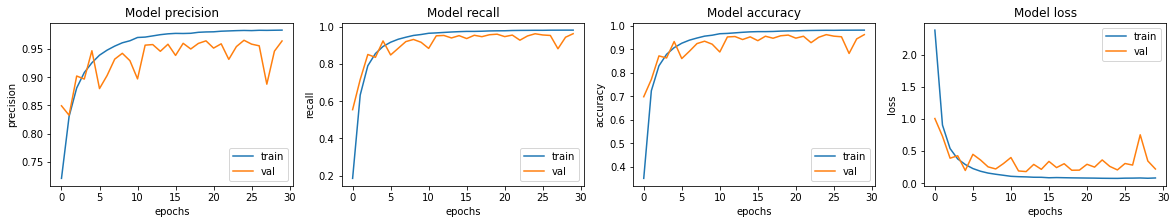

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(Info.history[met])
    ax[i].plot(Info.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [12]:
predictions = model.predict(test_dataset)

In [13]:
train_dataset.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Background_without_leaves': 4,
 'Blueberry___healthy': 5,
 'Cherry___Powdery_mildew': 6,
 'Cherry___healthy': 7,
 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 8,
 'Corn___Common_rust': 9,
 'Corn___Northern_Leaf_Blight': 10,
 'Corn___healthy': 11,
 'Grape___Black_rot': 12,
 'Grape___Esca_(Black_Measles)': 13,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 14,
 'Grape___healthy': 15,
 'Orange___Haunglongbing_(Citrus_greening)': 16,
 'Peach___Bacterial_spot': 17,
 'Peach___healthy': 18,
 'Pepper,_bell___Bacterial_spot': 19,
 'Pepper,_bell___healthy': 20,
 'Potato___Early_blight': 21,
 'Potato___Late_blight': 22,
 'Potato___healthy': 23,
 'Raspberry___healthy': 24,
 'Soybean___healthy': 25,
 'Squash___Powdery_mildew': 26,
 'Strawberry___Leaf_scorch': 27,
 'Strawberry___healthy': 28,
 'Tomato___Bacterial_spot': 29,
 'Tomato___Early_blight': 30,
 'Tomato___Late_blight': 31,
 'Tomato__

Accuracy: 0.9599353796445881
Precision: 0.9543715253919449
Recall: 0.9513043057838347
F1_score: 0.9517256320956562


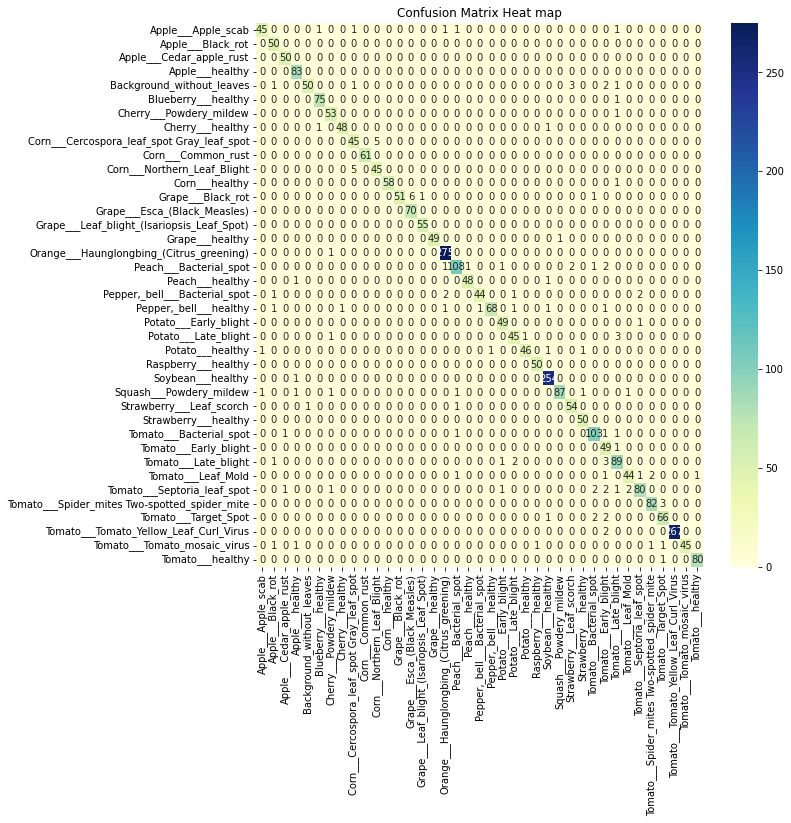

In [14]:
evaluate(test_dataset.classes,predictions)

In [15]:
model.evaluate(test_dataset)

31/31 [==============================] - 8s 264ms/step - loss: 0.2592 - accuracy: 0.9599 - precision: 0.9608 - recall: 0.9593


[0.25917848944664, 0.9599353671073914, 0.9608414173126221, 0.9592891931533813]

In [ ]:
model.save("plant_badr_model_v1-beta.h5")